In [1]:
import oda_api.token 
import logging
import numpy as np
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage, OdaLightCurve, OdaSpectrum
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.patches import Circle
from astropy.time import Time

In [2]:
# token = ''
# token = getpass.getpass('Insert the token')
token = oda_api.token.discover_token() # get token stored locally

In [3]:
logging.getLogger().setLevel(logging.INFO) # WARNING, INFO or DEBUG
logging.getLogger('oda_api').addHandler(logging.StreamHandler())

Import the ScWs from the saved file.

In [25]:
scw_ids = []
scw_versions = []
scw_start_times = []
scw_end_times = []
jupiter_ra = []
jupiter_dec = []

with open("../data/2004-01-01_2024-01-01.txt", "r") as f:
    next(f)
    for line in f:
        parts = line.strip().split(", ")
        scw_ids.append(parts[0])
        scw_versions.append(parts[1])
        scw_start_times.append(float(parts[2]))  
        scw_end_times.append(float(parts[3]))  
        jupiter_ra.append(float(parts[4]))  
        jupiter_dec.append(float(parts[5]))  

unique_sorted_data = {}
for sid, ver, start, end, ra, dec in sorted(zip(scw_ids, scw_versions, scw_start_times, scw_end_times, jupiter_ra, jupiter_dec), key=lambda x: x[0]):
    if sid not in unique_sorted_data:  
        unique_sorted_data[sid] = (sid, ver, start, end, ra, dec)

scw_ids, scw_versions, scw_start_times, scw_end_times, jupiter_ra, jupiter_dec = map(list, zip(*unique_sorted_data.values()))

Add IDs and versions together to make correctly formatted ScWs, and compute durations of the ScW observations.

In [31]:
scw_list = [id + "." + ver for id, ver in zip(scw_ids, scw_versions)]
scw_durations = [(end - start)*24*60 for start, end in zip(scw_start_times, scw_end_times)]
print(scw_list)
print(scw_durations)
print([Time(start, format='mjd').isot for start in scw_start_times])
print("Max duration in minutes:", np.max(scw_durations), "at position", np.argmax(scw_durations))

['026601100010.001', '026601110010.001', '026700000210.001', '026700000230.001', '043200640010.001', '043200650010.001', '091700010010.001', '091700020010.001', '106300180010.001', '106300190010.001', '112600220010.001', '112600230010.001', '124200010010.001', '124200020010.001', '168600570010.001', '168600580010.001', '169500010010.001', '169500020010.001', '230200070010.001', '230200080010.001', '230200090010.001', '230200160010.001', '230200170010.001', '230200180010.001', '230200470010.001', '230200480010.001', '230200490010.001', '230200550010.001', '230200560010.001', '230200570010.001', '230200570020.001', '236600410010.001', '236600420010.001', '236600440010.001', '236600450010.001', '236600460010.001', '236600470010.001', '236600480010.001', '236600490010.001', '236600500010.001', '236600510010.001', '236600520010.001', '236600530010.001', '236600540010.001', '236600550010.001', '236600560010.001', '236600570010.001', '236600580010.001', '236600590010.001', '236600600010.001',

In [54]:
from collections import defaultdict

scw_groups = defaultdict(list)

for idx, scw in enumerate(scw_list):
    R = scw[:4]  
    P = scw[4:8] 
    #scw_groups[(R, P)].append(idx)  
    scw_groups[R].append(idx)  

large_scw_groups = []

#for (R, P), indices in scw_groups.items():
for R, indices in scw_groups.items():
    if len(indices)>10:
        #print(f"Group R={R}, P={P}: SCWs at positions {indices} -> {', '.join([scw_list[i] for i in indices])}")
        print(f"Group R={R}: SCWs at positions {indices} -> {', '.join([scw_list[i] for i in indices])}")
        large_scw_groups.append([i for i in indices])

Group R=2302: SCWs at positions [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] -> 230200070010.001, 230200080010.001, 230200090010.001, 230200160010.001, 230200170010.001, 230200180010.001, 230200470010.001, 230200480010.001, 230200490010.001, 230200550010.001, 230200560010.001, 230200570010.001, 230200570020.001
Group R=2366: SCWs at positions [31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51] -> 236600410010.001, 236600420010.001, 236600440010.001, 236600450010.001, 236600460010.001, 236600470010.001, 236600480010.001, 236600490010.001, 236600500010.001, 236600510010.001, 236600520010.001, 236600530010.001, 236600540010.001, 236600550010.001, 236600560010.001, 236600570010.001, 236600580010.001, 236600590010.001, 236600600010.001, 236600610010.001, 236600620010.001
Group R=2367: SCWs at positions [52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74] -> 236700010010.001, 236700020010.001, 236700030010.001, 

In [62]:
# We found groups of ScWs with more than 10 consecutive pointings
# Let us check the dates and see they are really consecutive

group = large_scw_groups[0]

print([scw_list[i] for i in group])
print([Time(scw_start_times[i], format='mjd').isot for i in group])
print([scw_durations[i] for i in group])
print(len(group))

['230200070010.001', '230200080010.001', '230200090010.001', '230200160010.001', '230200170010.001', '230200180010.001', '230200470010.001', '230200480010.001', '230200490010.001', '230200550010.001', '230200560010.001', '230200570010.001', '230200570020.001']
['2020-11-26T22:58:31.199', '2020-11-26T23:10:19.199', '2020-11-27T00:07:35.201', '2020-11-27T06:50:03.216', '2020-11-27T07:47:35.218', '2020-11-27T09:25:33.221', '2020-11-28T15:31:23.285', '2020-11-28T16:28:38.287', '2020-11-28T17:25:54.289', '2020-11-28T23:10:51.302', '2020-11-29T00:08:22.304', '2020-11-29T01:05:38.306', '2020-11-29T02:04:29.308']
[9.883339195512235, 55.33336612279527, 55.33336612279527, 55.350032835267484, 95.76672322000377, 55.33336583990604, 55.33336684573442, 55.35003341152333, 55.35003341152333, 55.33336612279527, 55.350032835267484, 58.850034774513915, 37.083355193026364]
13


Query the ODA API.

In [ ]:
disp = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock")

for list_position in group:
    
    # Jupiter
    ra_deg = jupiter_ra[list_position]
    dec_deg = jupiter_dec[list_position]

    if Time(scw_start_times[list_position], format='mjd').isot > '2016':
        osa_version = "OSA11.2"
    else:
        osa_version = "OSA10.2"

    par_dict = {
    "RA": ra_deg,
    "DEC": dec_deg,
    "E1_keV": "15",
    "E2_keV": "30",
    "T_format": "isot",
    "detection_threshold": "5",
    "instrument": "isgri",
    "osa_version": osa_version,
    "product": "isgri_image",
    "product_type": "Real",
    "scw_list": [scw_list[list_position]],
    'token': token
    }

    data_collection = disp.get_product(**par_dict)
    im=OdaImage(data_collection)
    im.write_fits(f"../data/{scw_ids[list_position]}"+f".{scw_versions[list_position]}")

please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
- waiting for remote response (since 2025-03-10 13:41:49), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: RFMOW8Q27D9KEHZV job: 8e0bbfbd8d895624

... query status prepared => submitted
... assigned job id: 8e0bbfbd8d895624
 | the job is working remotely, please wait status=submitted job_id=8e0bbfbd in 0 messages since 4 seconds (4.9/4.9); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2025-03-10 13:41:55), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: RFMOW8Q27D9KEHZV job: 8e0bbfbd8d895624
 / the job is working remotely, please

Plot from the fits file.

Filename: 043200650010.001mosaic.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  GROUPING      1 BinTableHDU     82   4R x 16C   [8A, 32A, 1J, 1J, 256A, 3A, 32A, 1I, 1I, 1E, 1E, 1E, 1D, 1D, 1D, 1D]   
  2  ISGR-MOSA-IMA    1 ImageHDU        67   (507, 507)   float32   
  3  ISGR-MOSA-IMA    2 ImageHDU        67   (507, 507)   float32   
  4  ISGR-MOSA-IMA    3 ImageHDU        67   (507, 507)   float32   
  5  ISGR-MOSA-IMA    4 ImageHDU        67   (507, 507)   float32   


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  507                                                  
NAXIS2  =                  507                                                  
PCOUNT  =                    0 / number o

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 53854.223715 from DATE-OBS.
Set MJD-END to 53854.233970 from DATE-END'. [astropy.wcs.wcs]
/tmp/ipykernel_1887/2354898784.py:29: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(image_data), cmap='plasma', origin='lower')
/tmp/ipykernel_1887/2354898784.py:29: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(image_data), cmap='plasma', origin='lower')


Text(-14.048868921846264, 425.00372613394063, 'Jupiter (30x Rj)')

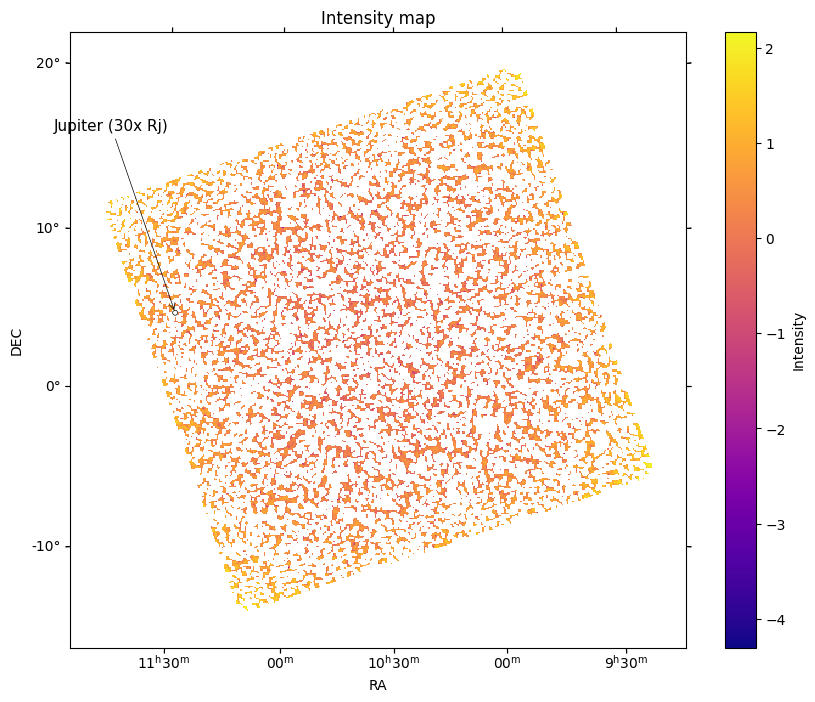

In [ ]:
countrates = []
variances = []
uncertainties = np.sqrt(variances)
exposuretimes = []

for list_position in group:

    fits_file = f"../data/{scw_list[list_position]}"+"mosaic.fits"

    pick = 2  # 2 for image, 3 for variance, 4 for significance and 5 for exposure map

    # Jupiter
    ra_deg = jupiter_ra[list_position]
    dec_deg = jupiter_dec[list_position]

    with fits.open(fits_file) as hdul:
        hdul.info()
        intensity_data = hdul[2].data 
        variance_data = hdul[3].data
        significance_data = hdul[4].data
        exposure_data = hdul[5].data
        print("\n")
        print(repr(hdul[pick].header))
        print("\n")
        print(hdul[1].data.columns)
        wcs = WCS(hdul[pick].header)  
        CD1 = np.abs(hdul[pick].header["CD1_1"])

    data = [intensity_data, variance_data, significance_data, exposure_data]
    image_data = data[pick-2]

    x, y = wcs.all_world2pix(ra_deg, dec_deg, 1)
    x_int, y_int = int(round(x.item())), int(round(y.item()))

    countrates.append(intensity_data[x_int, y_int])
    variances.append(variance_data[x_int, y_int])
    exposuretimes.append(exposure_data[x_int, y_int])

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection=wcs)
    im = ax.imshow(np.log10(image_data), cmap='plasma', origin='lower')

    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')

    pixel_scale = CD1 * 3600  # pixel size in arcseconds (|CD1_1| from fits header)
    circle_radius_pixels = 30 * 40 / pixel_scale / 2  # radius in pixels (30 times Jupiter's apparent size which is ~ 40")

    circle = Circle((x, y), circle_radius_pixels, edgecolor='black', facecolor='none', lw = 0.5)
    ax.add_patch(circle)

    title = ""
    if pick == 2:
        title = "Intensity"
    elif pick == 3:
        title = "Variance"
    elif pick == 4:
        title = "Significance"
    elif pick == 5:
        title = "Exposure"

    plt.title(title+" map")
    plt.colorbar(im, label="Intensity")

    ax.annotate(
        text="Jupiter (30x Rj)", 
        xy=(x, y),  
        xytext=(x - 100, y + 150),
        arrowprops=dict(arrowstyle="->", color="black", lw=0.5),
        fontsize=11,
        color="black"
    )

    plt.savefig(f"../data/{scw_list[list_position]}"+"_"+f"{title}.pdf", format='pdf', bbox_inches='tight')

In [ ]:
isot_start_times = [Time(scw_start_times[i], format='mjd').isot for i in group]
isot_end_times = [Time(scw_end_times[i], format='mjd').isot for i in group]

plt.figure()
plt.errorbar(isot_end_times, countrates, yerr=uncertainties, color='b', fmt='o', capsize=5)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Countrate (counts/s))', fontsize=14)
plt.title('Intensity over Time (SCWs)', fontsize=16)
plt.grid(True)
plt.legend()